In [26]:
"""Load the Boston dataset and examine its target (label) distribution."""

# Load libraries
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats.kde import gaussian_kde
from sklearn import datasets
from sklearn.cross_validation import ShuffleSplit, train_test_split, KFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

plt.style.use('bmh')

In [2]:
def load_data():
    """Load the Boston dataset."""

    boston = datasets.load_boston()
    return boston

In [3]:
def explore_city_data(city_data):
    """Calculate the Boston housing statistics."""

    # Get the labels and features from the housing data
    housing_prices = city_data.target
    housing_features = city_data.data

    ###################################
    ### Step 1. YOUR CODE GOES HERE ###
    ###################################

    # Please calculate the following values using the Numpy library

    # Size of data (number of houses)?
    n_rows = np.shape(city_data.data)[0]
    print 'Number of houses in data set: {}'.format(n_rows)

    # Number of features?
    n_features = np.shape(city_data.data)[1]
    print 'Number of features: {}'.format(n_features)

    # Minimum price?
    price_min = np.min(city_data.target)
    print 'Minimum house price in dataset: {0}'.format(price_min)

    # Maximum price?
    price_max = np.max(city_data.target)
    print 'Maximum house price in dataset: {0}'.format(price_max)

    # Calculate mean price?
    price_mean = np.mean(city_data.target)
    print 'Average house price: {0}'.format(price_mean)

    # Calculate median price?
    price_median = np.median(city_data.target)
    print 'Median house price: {0}'.format(price_median)

    # Calculate standard deviation?
    price_std = np.std(city_data.target)
    print 'House price standard deviation: {0}'.format(price_std)

In [4]:
def performance_metric(label, prediction):
    """Calculate and return the appropriate error performance metric."""

    ###################################
    ### Step 2. YOUR CODE GOES HERE ###
    ###################################

    return mean_squared_error(label, prediction)

In [5]:
def split_data(city_data, train_size=0.7, random=True):
    '''Randomly shuffle the sample set. Divide it into 70 percent training and
        30 percent testing data.

        Optionally, random flag can be set to False to return deterministic
            results for report analysis. Set to True by default for running
            multiple times in Monte Carlo Simulations.

    Args:
        city_data: (Numpy array): Boston Housing data from sklearn.datasets
        train_size (int): Size of training set to be returned.
        random (Boolean): Random seed flag for deterministic results.

    Returns:
        X_train (Numpy array): Training set features.
        y_train (Numpy array): Training set target.
        X_test (Numpy array): Test set features.
        y_test (Numpy array): Test set target.

    '''
    # Get the features and labels from the Boston housing data
    X, y = city_data.data, city_data.target

    ###################################
    ### Step 3. YOUR CODE GOES HERE ###
    ###################################

    random_state = None

    # Set a seed for the depth analysis graphs only
    if random != True:
        random_state = 333

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)
    return X_train, y_train, X_test, y_test

In [6]:
def learning_curve(depths, X_train, y_train, X_test, y_test):
    '''Calculate the performance of the model after a set of training data.

    1. Takes a list of depths to train
    2. Calls a helper function (train_decision_tree) to train a series
     of models at each depth.
    3. At each depth, a model is trained on varying amounts of training set
     sizes.
    4. All results are aggregated into a Pandas data frame.

    Example output format with 2 entries would be:

    {'Depth': [1, 1],
     'Training Error': [-0.2, -0.3],
     'Test Error': [-0.3, -0.25],
     'Size': [1, 2]}

     5. Results are plotted using the helper function learning_curve_graph_pd()

    Args:
        depths (List): List of depths
        X_train (Numpy array): Training set features.
        y_train (Numpy array): Training set target.
        X_test (Numpy array): Test set features.
        y_test (Numpy array): Test set target.

    Returns:
        null

    '''

    # We will vary the training set size so that we have 50 different sizes
    # Make as an argument to only create once and use for all call in the loop.
    num_of_sizes = 50
    sizes = np.round(np.linspace(1, len(X_train), 50))
    # Convert to ints to avoid numpy DeprecationWarning
    sizes = [int(x) for x in sizes]

    total_size = num_of_sizes * len(depths)

    # Initialize a empty Numpy arrays for all training/test errors
    train_err_all = np.empty(0)
    test_err_all = np.empty(0)

    # Repeat each depth value 50 times (num_of_sizes)
    depths_all = np.repeat(depths, num_of_sizes)

    # Repeat the sizes sequence (np.linspace()..) so each step is labeled in each depth
    size_all = np.resize(sizes, total_size)

    fill_index = 0

    for depth in depths:
        test_err, train_err = train_decision_tree(sizes, depth, X_test, X_train, y_test, y_train)

        train_err_all = np.append(train_err_all, train_err)
        test_err_all = np.append(test_err_all, test_err)

        fill_index += num_of_sizes

    learning_curve_df = pd.DataFrame({'Depth': depths_all,
                                      'Training Error': train_err_all,
                                      'Test Error': test_err_all,
                                      'Size': size_all})

    learning_curve_graph_pd(learning_curve_df)

In [7]:
def train_decision_tree(sizes, depth, X_test, X_train, y_test, y_train):
    """
    Args:
        sizes   (Numpy array): Array of training sample sizes to train on.
        depth   (int): The maximum depth of the DecisionTreeRegressor
        X_test  (Numpy array): Test set features
        X_train (Numpy array): Training set features
        y_test  (Numpy array): Test set target variable
        y_train (Numpy array): Training set target variable

    Returns:
        test_err  (Numpy array): Test set predictions.
        train_err (Numpy array): Training set predictions.
    """

    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))

    for i, s in enumerate(sizes):
        # Create and fit the decision tree regressor model
        regressor = DecisionTreeRegressor(max_depth=depth)

        # Cast to int to avoid DeprecationWarning from numpy 1.8
        regressor.fit(X_train[:int(s)], y_train[:int(s)])

        # Find the performance on the training and testing set
        train_err[i] = performance_metric(y_train[:s], regressor.predict(X_train[:s]))
        test_err[i] = performance_metric(y_test, regressor.predict(X_test))

    return test_err, train_err

In [8]:
def learning_curve_graph_pd(df):
    '''Plots error values as a function of training set size for each depth from
        the provided dataframe.

    Example dataframe with 2 entries.

    {'Depth': [1, 1],
     'Training Error': [-0.2, -0.3],
     'Test Error': [-0.3, -0.25],
     'Size': [1, 2]}

    Groups the dataframe by Depth, then plots error and training/test error on
        one plot.

    Args:
        df (Pandas dataframe): Pandas dataframe

    Returns:
        null
    '''

    # key = each Depth value
    # grp is each sub-dataframe filtered by the Depth value of 'key'
    fig = plt.figure(figsize=(16, 18))
    ax = fig.add_subplot(1,1,1)

    for i, key_group_pair in enumerate(df.groupby(['Depth'])):
        key, grp = key_group_pair
        each_ax = fig.add_subplot(5, 2, i + 1)
        #each_ax.set_ylim([0, 80])
        each_ax.set_title('Depth: {}'.format(i + 1))
        each_ax.plot(grp['Size'], grp['Test Error'])
        each_ax.plot(grp['Size'], grp['Training Error'])

    plt.suptitle('Train & Test set error as a function of training set size', fontsize=20)
    plt.legend(loc='best')

    # Turn off axis lines and ticks of the big subplot
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    ax.set_ylabel('Mean Squared Error',fontsize=20)
    ax.set_xlabel('Training set size', fontsize=20, horizontalalignment='center')

    plt.show()

In [9]:
def learning_curve_graph(sizes, train_err, test_err, show=True):
    """Plot training and test error as a function of the training size."""

    pl.figure()
    pl.title('Decision Trees: Performance vs Training Size')
    pl.plot(sizes, test_err, lw=2, label='test error')
    pl.plot(sizes, train_err, lw=2, label='training error')
    pl.legend()
    pl.xlabel('Training Size')
    pl.ylabel('Error')
    pl.show()

In [10]:
def model_complexity(X_train, y_train, X_test, y_test):
    """Calculate the performance of the model as model complexity increases."""

    print "Model Complexity: "

    # We will vary the depth of decision trees from 2 to 25
    max_depth = np.arange(1, 25)
    train_err = np.zeros(len(max_depth))
    test_err = np.zeros(len(max_depth))

    for i, d in enumerate(max_depth):
        # Setup a Decision Tree Regressor so that it learns a tree with depth d
        regressor = DecisionTreeRegressor(max_depth=d)

        # Fit the learner to the training data
        regressor.fit(X_train, y_train)

        # Find the performance on the training set
        train_err[i] = performance_metric(y_train, regressor.predict(X_train))

        # Find the performance on the testing set
        test_err[i] = performance_metric(y_test, regressor.predict(X_test))

    # Plot the model complexity graph
    model_complexity_graph(max_depth, train_err, test_err)

In [11]:
def model_complexity_graph(max_depths, train_err, test_err):
    """Plot training and test error as a function of the depth of the decision tree learn."""
    # Change to matplotlib.pyplot for pyplot.xticks() to accept a list in ipython

    plt.figure(figsize=(12, 9))
    plt.title('Decision Trees: Performance vs Max Depth')
    plt.plot(max_depths, test_err, lw=2, label='test error')
    plt.plot(max_depths, train_err, lw=2, label='training error')
    plt.xticks(max_depths)
    plt.legend()
    plt.xlabel('Max Depth')
    plt.ylabel('Error')
    plt.show()

In [12]:
def fit_predict_model(city_data, verbose=True):
    '''
    1. Splits the city_data into training/testing splits.
    2. Creates a performance scorer and k-fold object for training.
    3. Trains a DecisionTreeRegressor() model on training data using
     GridScoreCV()
     3a. If verbose is True, trains then predicts on one predefined sample then
      prints training info to stdout.
    4. Return fully trained GridScoreCV object containing best model.

    Args:
        city_data (Numpy array): Boston Dataset from sklearn.datasets
        verbose (Boolean): Whether to print out model statistics when done
            training the model.

    Returns:
        reg (GridScoreCV): A pre-trained GridScoreCV object.

    '''
    """Find and tune the optimal model. Make a prediction on housing data."""

    # Get the features and labels from the Boston housing data
    # Not needed in this version.
    # X, y = city_data.data, city_data.target

    # Setup a Decision Tree Regressor
    regressor = DecisionTreeRegressor()

    parameters = {'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)}

    ###################################
    ### Step 4. YOUR CODE GOES HERE ###
    ###################################

    # Training/Test dataset split
    # We'll give a larger train size split here since we will be doing K-fold grid search cross validation
    # over the training set and our dataset is not very big to being with.
    X_train, y_train, X_test, y_test = split_data(city_data, train_size=0.90)

    # 1. Find the best performance metric
    # should be the same as your performance_metric procedure
    # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html

    mse_scorer = make_scorer(performance_metric,  # Use our performance metric, which is just mean squared error(mse)
                             greater_is_better=False)  # False because we are trying to minimize a loss function, MSE

    # 2. Use gridearch to fine tune the Decision Tree Regressor and find the best model
    # http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV


    kfold_split = KFold(np.shape(X_train)[0],
                        n_folds=5,
                        random_state=None)

    reg = GridSearchCV(estimator=regressor,
                       param_grid=parameters,
                       scoring=mse_scorer,
                       n_jobs=4,
                       cv=kfold_split)

    # Fit the learner to the training data
    if verbose == True:
        print "Final Model: "
        print reg.fit(X_train, y_train)

        print "*" * 80
        print "Best Estimator: {0}".format(reg.best_estimator_)
        print ""
        print "Best Params: {0}".format(reg.best_params_)
        print "Mean Square Error of Best Model {0}".format(reg.best_score_)
        print "*" * 80

        # Use the model to predict the output of a particular sample
        # Changed to address changes in sklearn:
        # DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19.
        x = np.array([11.95, 0.00, 18.100, 0, 0.6590, 5.6090, 90.00, 1.385, 24,
                      680.0, 20.20, 332.09, 12.13]).reshape(1, -1)
        y = reg.predict(x)
        print "House: " + str(x)
        print "Prediction: " + str(y)
    else:
        # Just train the model using gridSearch but don't print anything if verbose is false.
        reg.fit(X_train, y_train)

    # Return our gridSearch object containing our best model.
    return reg


In [13]:
def fit_predict_many(city_data, n=100, verbose=False):
    '''Helper function to train 'n' models on the provided using the
    fit_predict_model to handle prediction internals.

    Args:
        city_data (Numpy array): Boston Dataset from sklearn.datasets
        n (int): Number of models to train.
        verbose (Boolean): Whether to print out model statistics when done
            training the model.

    Returns:
        best_max_depth_all (List):  List of 'n' GridScoreCV sklearn objects,
            each containing a best trained model on the dataset.

    '''

    best_max_depth_all = []
    for i in xrange(n):
        one_pass = fit_predict_model(city_data, verbose=verbose)
        best_max_depth_all.append(one_pass)

    return best_max_depth_all

In [14]:
def get_xval_data_from_GridScore(oneGridScoreObject):
    '''Extracts the best depth and a list of error scores from that depth
     from the pre-trained GridScoreCV object.

    Args:
        oneGridScoreObject (GridScoreCV): A pre-trained GridScoreCV object.

    Returns:
        best_depth (int): Best depth of the best model in the GridScoreCV
                          object

        best_depth_kfold_scores (List): List of the error scores from the best
                            depth.

    '''

    best_depth = oneGridScoreObject.best_params_['max_depth']

    # Array indexing starts at 0, so the index is [max_depth - 1]
    best_depth_kfold_scores = oneGridScoreObject.grid_scores_[best_depth - 1].cv_validation_scores

    return best_depth, best_depth_kfold_scores


In [15]:
def get_xval_data_from_list_Gridscores(manyGridScoreObjects):
    ''' Takes a list of pre-trained GridScoreCV objects and extracts the best
        depth and error scores from each GridScoreCV object.

    Multiple error results from same max depth are concatenated.

    Return as a dictionary with the following example format.

    Example of errors from 2 3-fold models with best max depth of 5 and
                           1 3-fold model  with best max depth of 6.

    example_dict = {5: [-0.4, -0.5, -0.2, -0.4, -0.2, -0.5],
                    6: [-0.3, -0.4, -0.4]}

    Args:
        manyGridScoreObjects (List): List of pre-trained GridScoreCV objects

    Returns:
        best_max_depths_all (dict): Python dictionary with best_depth as key
            and a list of error scores from best performing depth of each model.
    '''

    best_max_depths_all = {}

    for eachGridScoreObject in manyGridScoreObjects:

        # Pull out the loss for each fold in each best 'max depth' of each run.
        best_depth, best_depth_kfold_scores = get_xval_data_from_GridScore(eachGridScoreObject)

        try:
            best_max_depths_all[best_depth] = np.append(best_max_depths_all[best_depth], best_depth_kfold_scores)
        except KeyError:
            best_max_depths_all[best_depth] = best_depth_kfold_scores

    return best_max_depths_all

In [16]:
def unpack_dict_to_df(best_max_depths_all):
    ''' Unpacks dictionary into pandas dataframe.

    Example: Unpacks data from:

    dict({2, [-0.4, -0.3],
         4, [-0.5, -0.2]})

    To:

    pd.DataFrame({'Max Depth': [2, 2, 4, 4]
                  'Loss': [-0.4, -0.3, -0.5, -0.2]})

    Args:
        best_max_depths_all (Dict): Python dictionary containing best max depth
            as keys, and error values in list as values.

    Returns:
        (Pandas dataframe): Pandas dataframe with dictionary in tidy long data
            format.
    '''

    max_depths_all = []
    scores_all = []

    for key, value in best_max_depths_all.iteritems():
        max_depths = [key] * len(value)
        scores = list(value)

        max_depths_all += max_depths
        scores_all += scores

    return pd.DataFrame({'Max Depth': max_depths_all, 'Loss': scores_all})

In [17]:
def plot_all_distributions(best_depths):
    '''Takes a list of pre-trained GridScoreObjects, extracts error rates for
    each model from each "best" folds. Calculates the average error, and
    standard deviation from the best depth in each 5-fold run to plot as well.

     From each model, each fold's error is plotted. The average of each depth
     and standard deviation are also plotted.

    Args:
        best_depths (List): List of GridScoreCV objects

    Returns:
        null

    '''

    # iter - Store number of runs/GridSearchCV objects
    # k - Pull out the first GridSearchCV object and grab the k-folds used.
    best_depths_params = {'iter': len(best_depths),
                          'k': best_depths[0].cv.n_folds}

    best_max_depths_all = get_xval_data_from_list_Gridscores(best_depths)

    best_max_depths_df = unpack_dict_to_df(best_max_depths_all)

    best_max_depths_stats = best_max_depths_df.groupby(['Max Depth'], as_index=False)\
        .aggregate([np.mean, np.std])\
        .reset_index()

    # Add a bit of jitter to the max depth for each fold to avoid overplotting
    best_max_depths_df['Jitter Max Depth'] = best_max_depths_df['Max Depth']\
        .apply(lambda x: x*(1+np.random.uniform(-0.02, 0.02)))

    plt.figure(figsize=(12, 9))
    plt.xlim([0, 11])
    plt.xticks(range(0, 11))

    plt.gca().invert_yaxis()

    plt.scatter(best_max_depths_df['Jitter Max Depth'],
                best_max_depths_df['Loss'], alpha=0.3,
                color='#6734bd')

    plt.errorbar(best_max_depths_stats['Max Depth'],
                 best_max_depths_stats['Loss']['mean'],
                 yerr=best_max_depths_stats['Loss']['std'],
                 color='#bd6734',
                 capsize=10,
                 elinewidth=2,
                 markeredgewidth=1)

    plt.scatter(best_max_depths_stats['Max Depth'],
                best_max_depths_stats['Loss']['mean'],
                color='#bd6734',
                s=70, marker='o')

    plt.title('Mean Squared Error of best model of each fold \n'
              ' in each run:  {k}-fold CV,  {iter} iterations'.format(**best_depths_params))

    plt.xlabel('Best Max Depth')
    plt.ylabel('Mean Squared Error')

    plt.show()

In [18]:
def plot_hist_best_max_depths(best_depths):
    '''Takes a list of pre-trained GridScoreObjects, extracts the max_depth
    value found in each object, then plots a histogram from the resulting
    values.

    Args:
        best_depths (List): List of GridScoreCV objects

    Returns:
        null
    '''
    best_depths_list = [model.best_params_['max_depth'] for model in best_depths]

    plt.figure(figsize=(12, 9))
    # Remove unneeded plot frame lines and ticks.
    ax = plt.subplot(1, 1, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


    # Move the ticks over 0.5 units to be centered under bar; add ticks for every depth
    plt.xticks(np.arange(1.5, 11.5, 1), range(1, 12), fontsize=14)
    plt.xlabel('Best Max Depth', fontsize=16)
    plt.ylabel('Count', fontsize=16)

    plt.hist(best_depths_list, color="#3F5D7D", bins=range(1, 12), edgecolor='k')
    plt.title('Best "Max Depth": {0} Runs of GridSearchCV'.format(len(best_depths)))

    plt.show()

In [19]:
def plot_prediction_distribution(best_depths):
    ''' Takes a list of pre-trained GridScoreObjects, makes a predictions on one
    predefined data point with each object, then plots kernel density estimation
    plot with the predictions. Adds average value.

    Args:
        best_depths (List): List of GridScoreCV objects

    Returns:
        null
    '''


    x = np.array([11.95, 0.00, 18.100, 0, 0.6590, 5.6090, 90.00, 1.385, 24, 680.0, 20.20, 332.09, 12.13]).reshape(1, -1)
    y_predictions = [model.predict(x)[0] for model in best_depths]
    y_predictions_mean = np.mean(y_predictions)

    plt.figure(figsize=(12, 9))
    # Remove unneeded plot frame lines and ticks.
    ax = plt.subplot(1, 1, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    # http://stackoverflow.com/questions/15415455/plotting-probability-density-function-by-sample-with-matplotlib
    # https://en.wikipedia.org/wiki/Kernel_density_estimation
    # In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function of a random variable.

    kde = gaussian_kde(y_predictions)
    # these are the values over which your kernel will be evaluated
    # Add 2 to min/max to extend the curve
    dist_space = np.linspace(min(y_predictions)-2, max(y_predictions)+2, 100)
    y = kde(dist_space)



    plt.plot(dist_space, y, color="#348ABD")
    plt.fill_between(dist_space, 0, y, color='#348ABD', alpha=0.4)

    # Plot the average prediction of all of the models.
    plt.vlines(y_predictions_mean,
               ymin=0, ymax=1,
               colors=['#bd6734'],
               linestyles="--",
               lw=2,
               label='Avg. Predicted Price: {:,}'.format(int(round(y_predictions_mean, 3)*1000)))

    # Plot the actual predictions as well.
    dist_space_predictions = kde(y_predictions)

    plt.vlines(y_predictions,
               ymin=0,
               ymax=dist_space_predictions,
               colors=['#348ABD'],
               linestyles='--',
               lw=0.5,
               label='Each Predicted Price')

    plt.legend()
    plt.title(
        'Estimated Probability Density for Predictions of Each Best Max Depth Model \n'
        ' over {0} different runs of gridSearch'.format(len(best_depths)))
    plt.xlabel('Predicted Value', fontsize=16)
    plt.ylabel('Probability', fontsize=16)
    plt.xticks(fontsize=14)



In [33]:
def plot_price(city_data):
    ''' Plots a simple histogram with custom bins, xlabels, and labels.

    Args:
        city_data (Numpy array): Boston Dataset from sklearn.datasets

    Returns:
        null

    '''
    plt.figure(figsize=(12,9))
    bins = range(5, 51, 1)
    plt.hist(city_data.target, bins, color="#3F5D7D")
    plt.xticks(range(5, 51, 2))
    plt.title('Histogram of Prices from Full Dataset')
    plt.xlabel('Price (in $1000 bins)')
    plt.ylabel('Frequency')
    plt.show()

In [21]:
# Load data
city_data = load_data()

# Training/Test dataset split
X_train, y_train, X_test, y_test = split_data(city_data, random=False)

# Learning Curve Graphs
# Move logic/flow control out of main() and pass list as argument to our learning_curve function.
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [22]:
# Tune and predict Model
one_pred = fit_predict_model(city_data, verbose=False)

In [23]:
# Tune and predict Model over many iterations.
many_iter = fit_predict_many(city_data, n=100)

# Statistical Analysis and Data Exploration

This analysis is done on the [Boston House Prices dataset.](http://archive.ics.uci.edu/ml/datasets/Housing)

There are 13 features to predict with:


Attribute Information (in order):

- CRIM     per capita crime rate by town

- ZN       proportion of residential land zoned for lots over 25,000 sq.ft.

- INDUS    proportion of non-retail business acres per town

- CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

- NOX      nitric oxides concentration (parts per 10 million)

- RM       average number of rooms per dwelling

- AGE      proportion of owner-occupied units built prior to 1940

- DIS      weighted distances to five Boston employment centres

- RAD      index of accessibility to radial highways

- TAX      full-value property-tax rate per \$10,000

- PTRATIO  pupil-teacher ratio by town

- B        $1000(Bk - 0.63)^2$ where Bk is the proportion of blacks by town

- LSTAT    % lower status of the population

The target variable to be predicted is:

- MEDV     Median value of owner-occupied homes in \$1000's



Other summary statistics include:

In [24]:
explore_city_data(city_data)

Number of houses in data set: 506
Number of features: 13
Minimum house price in dataset: 5.0
Maximum house price in dataset: 50.0
Average house price: 22.5328063241
Median house price: 21.2
House price standard deviation: 9.18801154528


Here the median is about $1,300 less than the average. This suggests a positive skew in the price distribution with some high priced homes pulling the average away from the bulk of the data. (More on this later in the model analysis section)

# Evaluating Model Performance

## The Loss Function - What to choose?


Mean Squared Error (MSE) was chosen as the loss function to minimize when assessing the quality of our predictor of house price.



## What's so great about MSE for our problem?

##### Pros

- __Our problem is a regression problem.__

Other measurements such as accuracy or f1 score are obvoiusly not used because they are classification measurements. We are trying to predict a semi-continuous variable (measures in dollars/cents) in house price.

- __Mean Squared Error penalizes bigger errors quadratically the more wrong they are.__

I would argue this is useful when predicting house prices because we want to maximize profit/ minimize cost as much as possible and getting too far from a good price is worse they further we get.

Mean absolute error is a possible alternative, but was not used since I felt being off from a good price gets worse the further you are, and MSE penalizes this better.

This is in part due to the nature of the data. If we were using our model to predict house sell price, being off by a little from the optimal price means we lose a bit of money (or gain a bit, yay). 

But being off by too much could mean we get no offers, and the house misses opportunities to sell during peak sell months (and staying on the market longer possibly negatively affecting the potential sell price.)

- __Mean Squared Error takes in account both the bias and variance of the model.__

Minimizing Mean Squared Error minimizes bias and variance simultaneously. 

Our model is hoping to approximate the true relationship between our chosen model/parameters and the price of houses. 

There are three sources of error preventing this.

- $\epsilon$: irreducible error

    1. This is error/noise that is inherent in our data. This can be any myriad of other attributes of the data that make the data slightly noisy, and unable to be modeled perfectly by a given model of given complexity.
    
    This noise is randomly distributed with 0 mean (otherwise it would have predictive value.)
    
    2. This also includes the amount of inherent error/noise that we can't reduce given a specific model and complexity (bias error.)
    
---

- $bias$

    This is how well our chosen model can model the true relationship/model between the data and the price.
    
    If we were run our same model, N-number of times on N-number of samples from the population, we could get an average model fit. 
    
    Bias would be how far off from this average model is from the true model (in the limit as N approaches the population size.)
    
    More explicitly:
    
    $bias = model_{True} - \hat{model_{Avg}}$
    
    **_where_**:
    
    $\hat{model_{Avg}}$ = $\dfrac{\hat{model}_{sample1} + \hat{model}_{sample2} + ... + \hat{model}_{sampleN}}{N}$ 
    
    A simpler model would have higher bias because it would be, on average, further from the true model. It would be biased toward itself, regardless of the true model. 
    
    This is known as underfitting.
    
    Models with higher complexity are much more flexible, so are able to **_on average_** ($\hat{model}_{Avg}$) fit a given function better giving them lower bias.
    
___

- $variance$

    Variance is how much each individiual model varies from the average model when given a new sample of data.
    
    This difference is then squared and averaged across all possible samples with our given model.
    
    More explicitly:
    
    $variance$ = $$\dfrac{1}{N}\sum_{sample(i)=1}^{N}({model_{True} - \hat{model}_{sample(i)}})^2$$

    A more complex model has higher variance because it has more flexibility to bend itself to a new sample data each time it sees new data. It would be able to fit each new sample dataset better, but have more variation between different sample datasets, and lose some generalizability to unseen data sets.
    
    This is known as overfitting.
    
    Simpler models are less impressed with new data, and give more consistent predictions when generalizing to new data.
    
___

Mean Squared Error is [$bias^2 + variance + \epsilon^2$](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). There is a bias-variance tradeoff, as we reduce one - in general the other will rise. Minimizing mean squared error seeks to find a balance between the minimization of both.

##### Cons

One possible drawback though might be that Mean Squared Error heavily weighs outliers since it is an average of _squared_ errors. This is can be an issue depending on our application, or the distribution of the target variable being predicted.

---

## Training, validating, and testing

Training, validation, and testing splits are absolutely vital when trying to evaluate a model, or when picking a set of parameters in a chosen model. 

We should be careful to find and tune our models using cross-validation on a validation set. Then once we are confident we have a good model and parameter settings, we should test once on another test set of unseen data.

If we don't have enough data or computational resources, K-fold cross-validation only can be a compromise. K-fold cross-validation holds out K-fold amount of data within our training set to predict on for each of it's iterations. 

---




### What K and why?

For this analysis, we'll use 5-fold cross validation instead of the default of 3.


 
If K is too low, the amount of data for training the model (66% in the case of 3-fold) would be lower not giving our model as much data to train on. This can cause higher variance between models trained
 
We also don't want to k-fold splits to be too high, since as K approaches N (the number of data points in our data set), we would have more and more overlap in training data used to train on. This would make all of the models more and more correlated with each other as K approaches N. This might cause another type of higher variance in our predicted models since ["In general, if the variables are correlated, then the variance of their sum is the sum of their covariances".](http://stats.stackexchange.com/questions/61783/variance-and-bias-in-cross-validation-why-does-leave-one-out-cv-have-higher-var)

Ideally we would want to split once around 70%/30% train/test.

Run Kfold cross-validation on a 70% training set only, then test once only on the 30% hold-out test set.

Or with enough data, further split the training set into training/validation sets,
train on the training set while scoring on the hold-out validation set to adjust our model parameters.

Then once done fine-tuning, run our model once on the 30% hold-out test set to get an idea of the out-of-sample performance.

But again, this would require more data since so many splits would reduce the predictive power of our model, causing higher variance.

## Pitfalls of ignoring data splitting

The biggest problem faced when not splitting the data is overfitting to the data set and having poor generalizability to new unseen data when making predictions.

If the data is not split at all using any of these methods, there can be an almost guarenteed risk of overfitting to the sample dataset.

In general, training error will continue to go down as a model becomes more complex. It will fit the model to the dataset, but have poor generalizability when predicting on new unseen data.

---

## Grid Search to the rescue

Grid search searches over a combination of different models and/or model parameters. It looks for the best combination to minimize your loss function (or maximize a reward function.)

## Verifying our search

Cross validation is important because, once again, we run the very big risk of overfitting to our particular sample dataset as we search for the very best combination to minimize loss on our model with our sample data.


## Warning: Not so fast!

Cross-validation is not a panacea. We can overfit even when using cross-validation. If we ["torture the data long enough, it will always confess"](https://en.wikiquote.org/wiki/Ronald_Coase).

As we try more and more combinations of parameters, ever higher levels of complexity, we get closer and closer to any one of those combinations returning a minimum loss score by random chance instead of modeling the behavior of the population data of our sample.

This is why it is important to, when we have enough data, have a validation set for cross-validation and a test to evaluate our model that cross-validation chose.

----

# Analyzing Model Performance

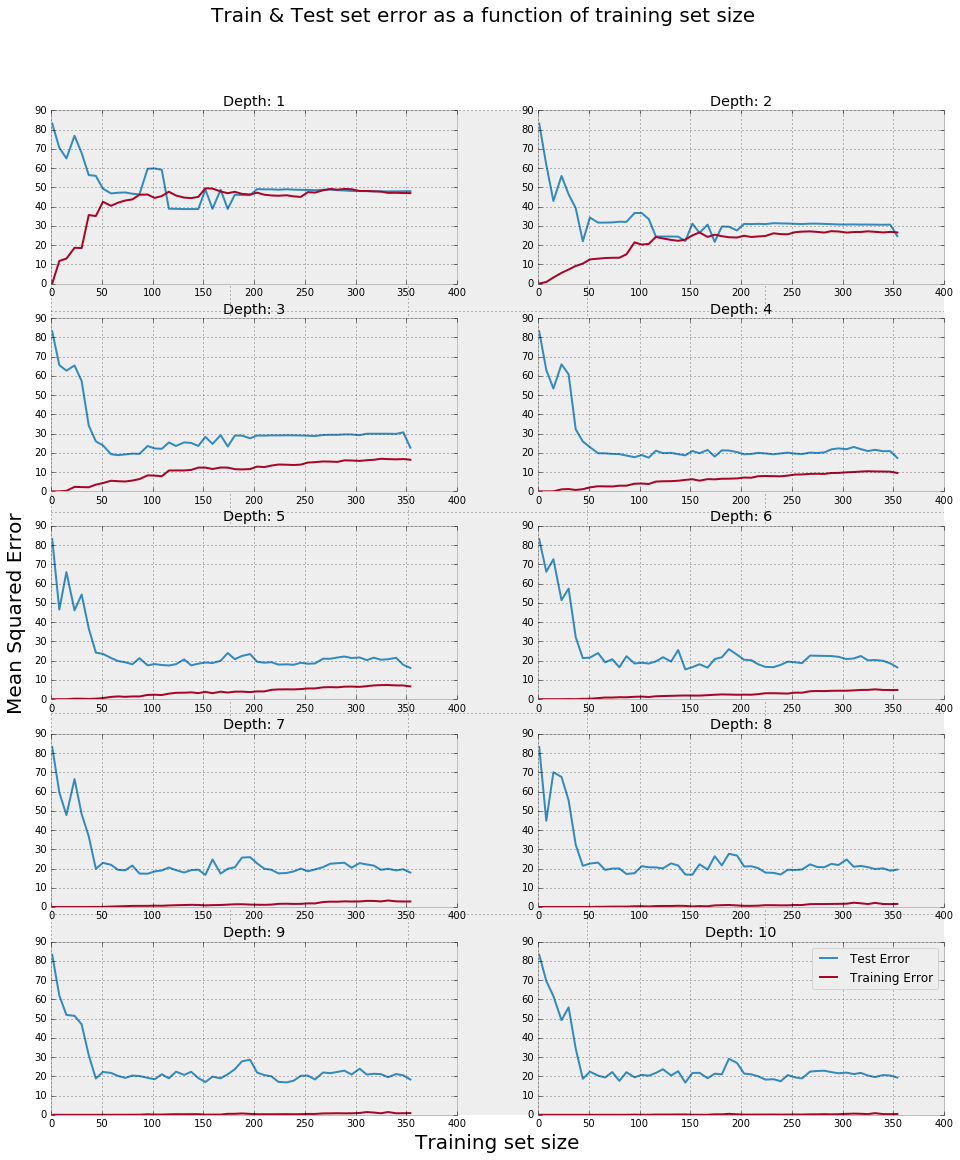

In [27]:
learning_curve(max_depths, X_train, y_train, X_test, y_test)

## General Trends with respect to Training Size

### Test error

At a very small training set size, no good model of the data can be learned on such little data and test error is high regardless of which max depth is used.

As the training set size increases, the model has more data to learn on, and the test error drops accordingly, up to a limit (discussed further in the next section on train/test error convergence.) 

### Training Error

The training error also increases with training set size. This increase is larger for simpler model parameters (max depths closer to 1) since such a simple model cannot hope to accurately measure the complexity of the data. 

As the max depth is increased, training error still increases, but much less so since it is now able to fit the the data better.

### Training and test error convergence

Also note that as training size increases, training and test error converge. This convergence is to the limit of error __*for each given model and model complexity*__. 

This limit is the combination of the irreducible error from:

 1. Inherent noise in the data.
 
 2. Bias error of the given model and complexity.


But this convergent error value won't go to zero (plus noise) because even with all of data in the world, a given model with given complexity may not be flexible enough to capture the true relationships to predict price perfectly.

But in the limit of training set size as it approaches all the data possible, the test error and training error should converge to the same value.

### Simple vs. complex

#### Depth 1

If we take a closer look at depths 1 and 10 for this particular data split, we can see that the training error of the simpler model converges with the test error at around a training size of 50. It has already hit the error limit (data noise + bias error.) The model can't hope to go below a Mean Squared Error of 50 no matter how much data it sees since it is too simple to model price. 

This shows the model to be highly biased, regardless of new data and underfitting the data.

#### Depth 10

Here the more complex model has lower test error and training error, but they are no longer very close. The training error is far lower (almost zero) while the test error sits at around 20 Mean Squared Error. 

The model makes predictions on the training set extremely well all the way to the full 352 samples while the out-of-sample test error is far higher. This indicates overfitting.

### Best of both worlds

If we look further at depths 4 and 5, the training error is much closer to the test error making it less biased and better able to predict the test error. The two also converge at a bit under 20 MSE, lower than depths 1-3, while still remaining close. The error then creeps back up to around 20 at higher depths.

### Is it really too complex?

We see that the test error is still fairly low at higher depths, but the training error doesn't quite match up. What will happen with more data? It's possible that more complexity/depth helps predict price, and with more data, the test error will drop (it's been stuck at 20 since depth 4.) But it's also possible that it's hit the limit of the noise plus model bias. It's impossible to tell without more data, and higher complexity is currently overfitting.

For now, depths 4-5 looks to be the best depths that minimize overfitting and error with our data available.

----

Model Complexity: 


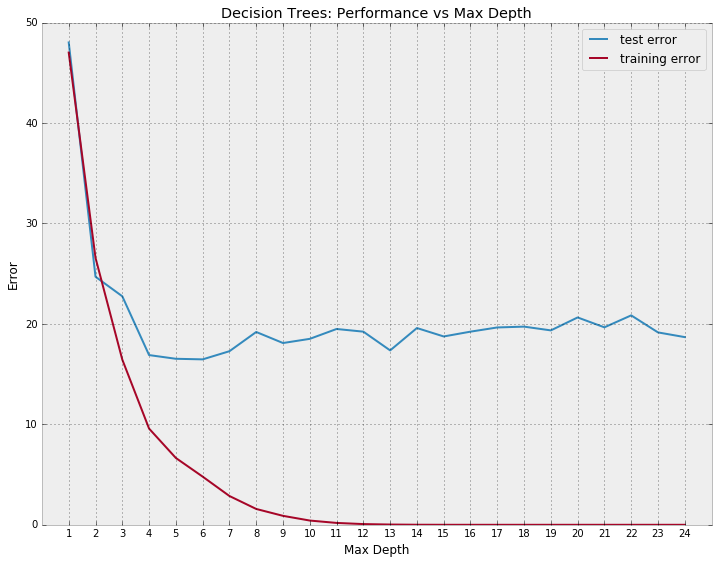

In [28]:
# Model Complexity Graph
model_complexity(X_train, y_train, X_test, y_test)

### Model Complexity - Test and training set relationship

I would argue that test error reaches its minimum around depths 4-5. Training set error continues to drop as the model gets more complex. As a model becomes more complex, it's better able to model every sample the training set data.

But as we can see, test error plateaus, while training error tended to zero. This is the model overfitting to the training set, while not adding anything to generalizability.

----

# Model Prediction

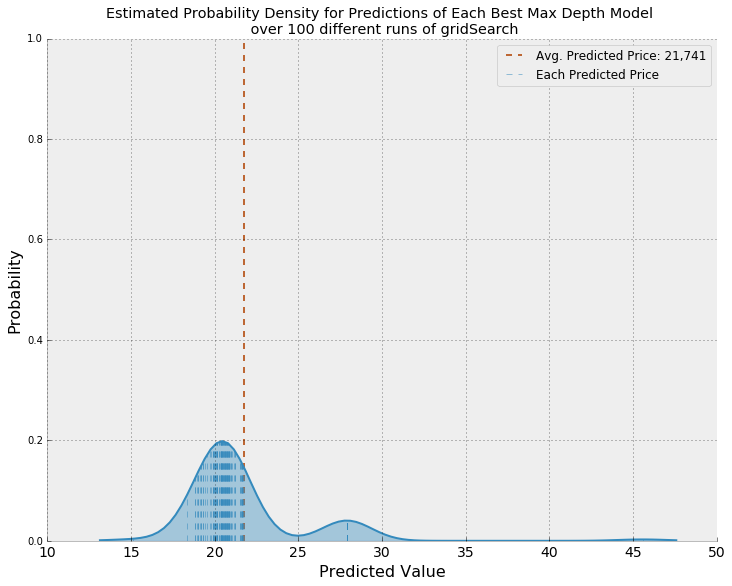

In [29]:
# plot_hist_best_max_depths(many_iter)
plot_prediction_distribution(many_iter)

### Smoothing out randomness

Due to the small data set size, randomness can occur when reporting predictions with models trained after the training/test splits. 

In an effort to help to alleviate this randomness, kernel density estimation was used to estimate the probability density function of the housing price based on 100 different runs with 100 predictions.

On average, over 100 different runs, the trained model predicted around $21,700 for the sample house.

In fact, we can see that the bulk of estimates and probability lie around \$20,500 but at least one model predicted a very high price pulling the average with it! 

In any case, this compares favorably to the average house price of $22,530, even if under-predicting the price a bit on average.

Also, the model does, on average, predict very close the median price of $21,200.

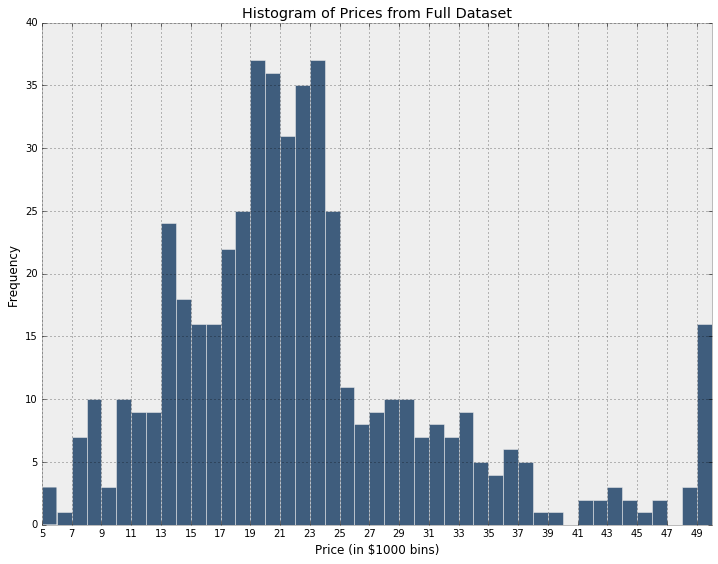

In [34]:
plot_price(city_data)

### Compared to the true distribution

In our post-mortem analysis, if we look at the true distribution, we can see some high value prices skewing the average.

Perhaps our models can be forgiven for over-predicting heavily when given certain random splits of the data!

---

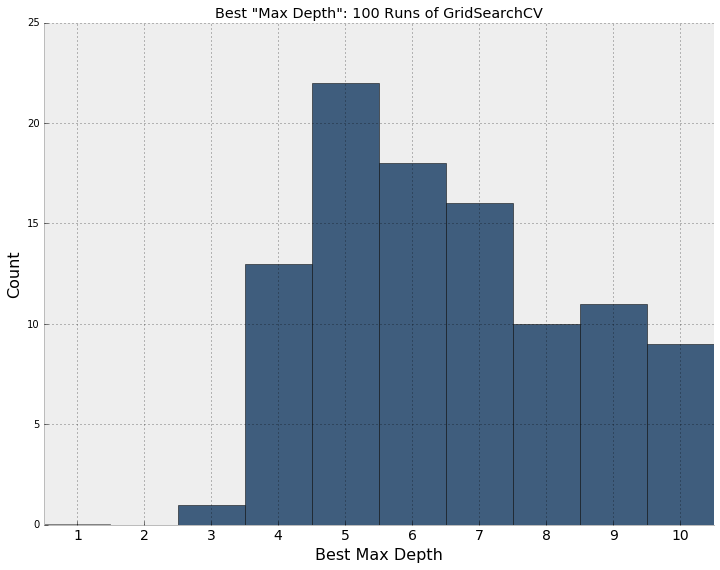

In [31]:
plot_hist_best_max_depths(many_iter)

### Best of the best

Over 100 runs of grid search with different splits of the data each time, we find that a depth of 5 is most common. The distribution is also right-skewed.

This agrees with what we saw in our model complexity plot (of one model.) There was a definite hinge at around a depth of 5.

There seems to some variability in depths chosen. This is possibly due in part to the size of the data set. 

The data used was on the small side at 506. They were also split out in a 90/10 train/test split before each run to simulate real-world application. This left 455 samples sent to cross-validation. At 5-Fold cross-validation, each model was trained on 364 samples, and tested on 91 samples in each fold.

---

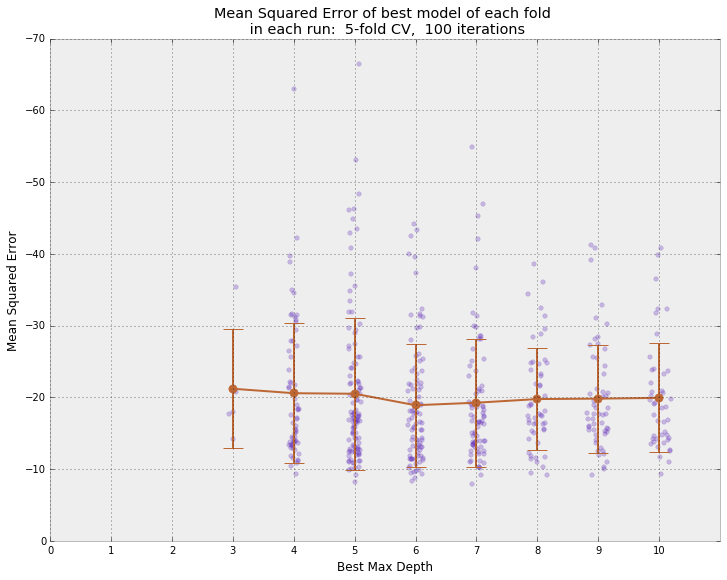

In [32]:
plot_all_distributions(many_iter)

### Spread of errors

We can see the variation of the error by looking at the spread of errors from within each fold of each best depth model. 

Here there are 100 models trained, with the best model of each run picked accroding to the lowest 5-fold average error. From each model, each fold's error is plotted. So there a total of 500 MSE values (100 runs x 5 folds each) from the best models. 

We also see error bars showing the standard deviation from the of each max depth's scores. 

We can see that most values do fall within one standard deviation but there are a fair amount of folds where the error was much higher than usual. 

Again, the smallish dataset may account for some of the variability but of course, the model itself is a fairly simple decision tree. 

### Is it any good?

Although it consistently underpredicts the true value, this seems like a reasonable model for prediction since the target variable itself has high value homes pushing the average price up.

If looking for better overall predictions, a random forest regressor might give it a little push in the right direction.

----